In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs

import os
import time

plt.rcParams.update({'font.size':18})

In [2]:
layers = [3] + [30]*10 + [1]

In [3]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)

    
model_psi = MLP(layers)
model_p = MLP(layers)
model_phil = MLP(layers)
# model

In [4]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [5]:
class PINN(nn.Module):
    def __init__(self, model_psi, model_p, model_phil, mu=None, sigma=None):
        super(PINN, self).__init__()
        self.model_psi = model_psi
        self.model_p = model_p
        self.model_phil = model_phil
        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
    
    def forward(self, X_res_psi, X_res_p, X_res_phil,  u_data, v_data, p_data, phil_data):
        u_pred, v_pred = self.net_psi(X_res_psi)
        loss_u = torch.mean((u_pred-u_data)**2)
        loss_v = torch.mean((v_pred-v_data)**2)
        loss_p = torch.mean((self.net_p(X_res_p)-p_data)**2)
        loss_phil = torch.mean((self.net_phil(X_res_phil)-phil_data)**2)
        loss = loss_u + loss_v + loss_p + loss_phil
        return loss, loss_u, loss_v, loss_p, loss_phil
    
    def net_psi(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        X.requires_grad_(True)
        psi = self.model_psi(X)
        
        grad_psi = grad(psi, X)[0]
        
        u_pred = grad_psi[:,[1]]
        v_pred = -grad_psi[:,[0]]

        return u_pred, v_pred
    
    def net_p(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.model_p(X)
    
    def net_phil(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.model_phil(X)
    

pinn = PINN(model_psi, model_p, model_phil)

In [6]:
model_path = r'./model'
model_state = torch.load(os.path.join(model_path, 'pinn_lbfgs.pth'))
pinn.model_psi.load_state_dict(model_state['model_psi_state'])
pinn.model_p.load_state_dict(model_state['model_p_state'])
pinn.model_phil.load_state_dict(model_state['model_phil_state'])

<All keys matched successfully>

In [7]:
# Load Data
data = scipy.io.loadmat('../Data/MultiBubbleData_TDN.mat')
# tdata = scipy.io.loadmat('../Data/t.mat')
# pdata = scipy.io.loadmat('../Data/p.mat')
# udata = scipy.io.loadmat('../Data/u.mat')
# vdata = scipy.io.loadmat('../Data/v.mat')
# phildata = scipy.io.loadmat('../Data/phi.mat')
print(data.keys())
u_star = data['u'] # N x T
v_star = data['v'] # N x T
P_star = data['p'] # N x T
Phil_star = data['phil'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = u_star # U_star[:,0,:] # N x T
VV = v_star # U_star[:,1,:] # N x T
PP = P_star # N x T
Phil = Phil_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1
phil = Phil.flatten()[:,None] # NT x 1

X_psi = np.concatenate([x, y, t], axis=1)
X_p = np.concatenate([x, y, t], axis=1)
X_phil = np.concatenate([x, y, t], axis=1)

# Training Data
# 3/4 of the data is for training 
idx = np.random.choice(N*T, int(N*T*0.75), replace=False)
x_train = x[idx,:] # [idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]
p_train = p[idx,:]
phil_train = phil[idx,:]
X_train_psi = np.concatenate([x_train, y_train, t_train], axis=1)
X_train_p = np.concatenate([x_train, y_train, t_train], axis=1)
X_train_phil = np.concatenate([x_train, y_train, t_train], axis=1)

print(X_train_psi.shape)
print(X_psi.shape)
u.shape[0]-u_train.shape[0]

def get_lb_ub(X_res):
    x = X_res[:,[0]]
    y = X_res[:,[1]]
    t = X_res[:,[2]]
#     lb = np.array([x.min(), y.min(), t.min()])
    lb = torch.tensor([x.min(), y.min(), t.min()])
#     ub = np.array([x.max(), y.max(), t.max()])
    ub = torch.tensor([x.max(), y.max(), t.max()])
    return lb, ub
X_star

t_train = t_train.astype(x_train.dtype)
t_train.dtype

dict_keys(['__header__', '__version__', '__globals__', 'X_star', 'p', 'phil', 't', 'u', 'v'])
(285274, 3)
(380366, 3)


dtype('<f8')

In [8]:
# Test Data
pinn.eval()
snap = np.array([50]) # time step --> insert the time step to be predicted

x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

X_star = np.concatenate([x_star, y_star, t_star], axis=1)
X_star = torch.from_numpy(X_star).float()

u_star = u_star[:,snap]
v_star = v_star[:,snap] 
p_star = P_star[:,snap]
phil_star = Phil_star[:,snap]

# Prediction
model_psi = model_psi.cpu()
# model_v = model_v.cpu()
model_p = model_p.cpu()
model_phil = model_phil.cpu()

# u_pred = model_u(X_star).detach().numpy()
u_pred, v_pred = pinn.net_psi(X_star)
p_pred = model_p(X_star).detach().numpy()
phil_pred = model_phil(X_star).detach().numpy()

u_pred = u_pred.detach().numpy()
v_pred = v_pred.detach().numpy()

# Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
error_phil = np.linalg.norm(phil_star-phil_pred,2)/np.linalg.norm(phil_star,2)

error_u_abs = (u_star-u_pred)
error_v_abs = (v_star-v_pred)
error_p_abs = (p_star-p_pred)
error_phil_abs = (phil_star-phil_pred)

print('Error abs u: %e' % (error_u))    
print('Error abs v: %e' % (error_v))    
print('Error abs p: %e' % (error_p))  
print('Error abs phil: %e' % (error_phil))            

# Predict for plotting
# lb = X_star.min(0)
# ub = X_star.max(0)
# nn = 200
# x = np.linspace(lb[0], ub[0], nn)
# y = np.linspace(lb[1], ub[1], nn)
# X, Y = np.meshgrid(x,y)

np.savetxt("u_pred_single.txt", np.hstack(u_pred))
np.savetxt("v_pred_single.txt", np.hstack(v_pred))
np.savetxt("p_pred_single.txt", np.hstack(p_pred))
np.savetxt("phil_pred_single.txt", np.hstack(phil_pred))

np.savetxt("u_error_single.txt", np.hstack(error_u_abs))
np.savetxt("v_error_single.txt", np.hstack(error_v_abs))
np.savetxt("p_error_single.txt", np.hstack(error_p_abs))
np.savetxt("phil_error_single.txt", np.hstack(error_phil_abs))

Error abs u: 7.460725e-02
Error abs v: 5.349275e-01
Error abs p: 4.703957e-04
Error abs phil: 6.260568e-01


In [24]:
lam_u = 2
lam_v = 0.9999
lam_p = 10
lam_phil = 0.991
X_star = np.concatenate([x_star, y_star, t_star], axis=1)
X_star = torch.from_numpy(X_star).float()

u_pred, v_pred = pinn.net_psi(X_star)
u_pred = u_pred.detach().numpy()
v_pred = v_pred.detach().numpy()
p_pred = model_p(X_star).detach().numpy()
phil_pred = model_phil(X_star).detach().numpy()


d_u = u_star-u_pred
d_v = v_star-v_pred
d_p = p_star-p_pred
d_phil = phil_star-phil_pred

u_pred = u_pred -lam_u*d_u
# v_pred = v_pred +lam_v*d_v
p_pred = p_pred -lam_p*d_p
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

# phil_pred = phil_pred +lam_phil*d_phil
error_phil = np.linalg.norm(phil_star-phil_pred,2)/np.linalg.norm(phil_star,2)

X_star = X_star.detach().numpy()
error_v,error_phil

print('Error abs u: %e' % (error_u))    
print('Error abs v: %e' % (error_v))    
print('Error abs p: %e' % (error_p))  
print('Error abs phil: %e' % (error_phil))   

Error abs u: 2.238218e-01
Error abs v: 5.349275e-01
Error abs p: 5.174352e-03
Error abs phil: 6.260568e-01


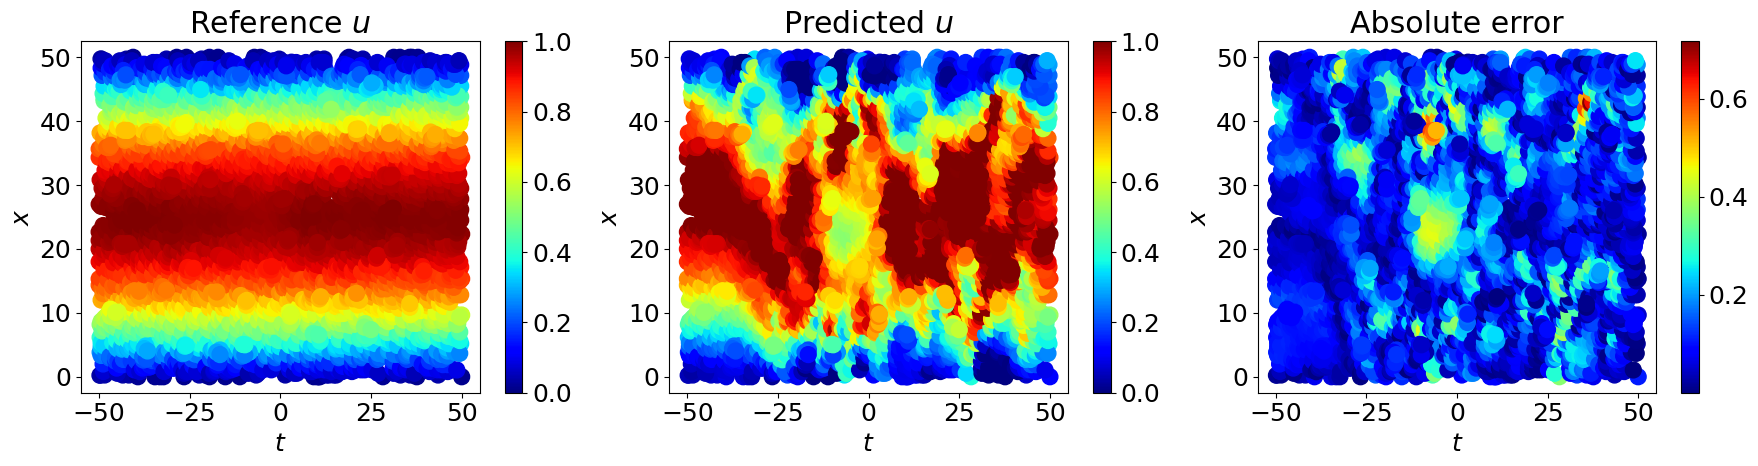

In [25]:
# 用scatter
# 与真实解的对照图
# xx = X
# yy = T
# X_star = X_star.detach().numpy()

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
# plt.pcolor(yy, xx, u_star.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = u_star, s = 130, cmap='jet')
plt.colorbar()
plt.clim([0, 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $u$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = u_pred, s = 130, cmap='jet')

plt.colorbar()
plt.clim([0, 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, np.abs(u_true.reshape(xx.shape) - u_pred.reshape(xx.shape)), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = np.abs(u_star - u_pred), s = 130, cmap='jet')

plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.savefig('result_u.png', dpi=100)
plt.show()

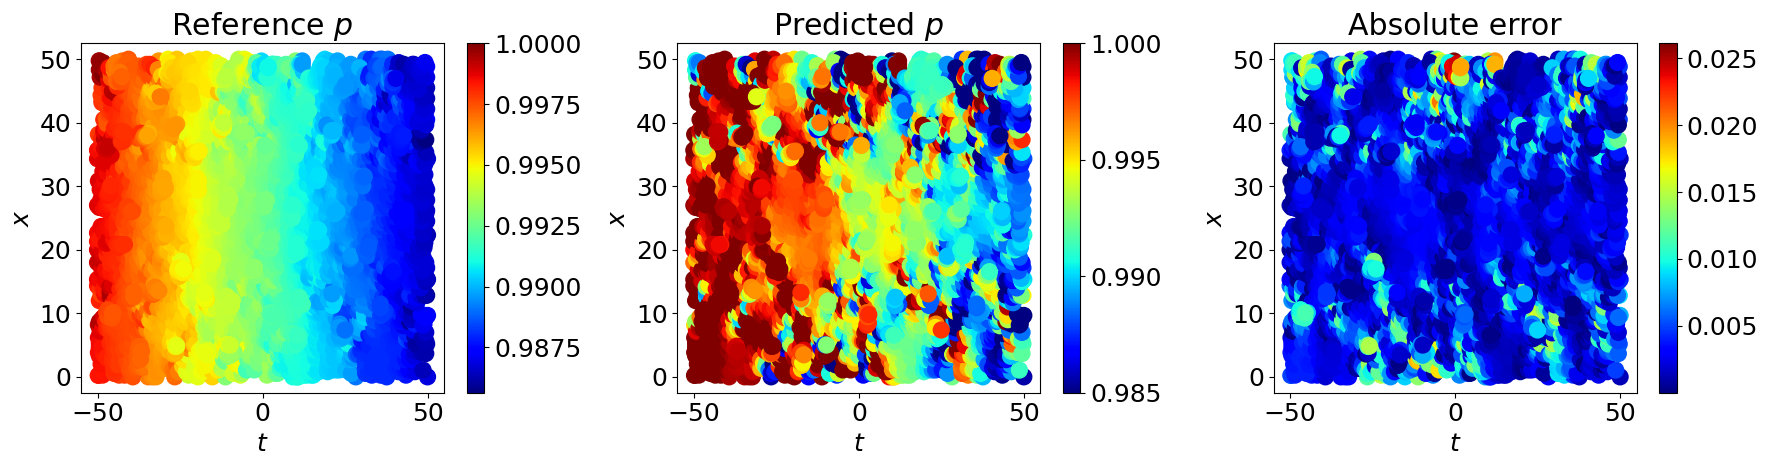

In [27]:

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
# plt.pcolor(yy, xx, u_star.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = p_star, s = 130, cmap='jet')
plt.colorbar()
# plt.clim([0.985, 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $p$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = p_pred, s = 130, cmap='jet')

plt.colorbar()
plt.clim([0.985, 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $p$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, np.abs(u_true.reshape(xx.shape) - u_pred.reshape(xx.shape)), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = np.abs(p_star - p_pred), s = 130, cmap='jet')

plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.savefig('result_p.png', dpi=100)
plt.show()

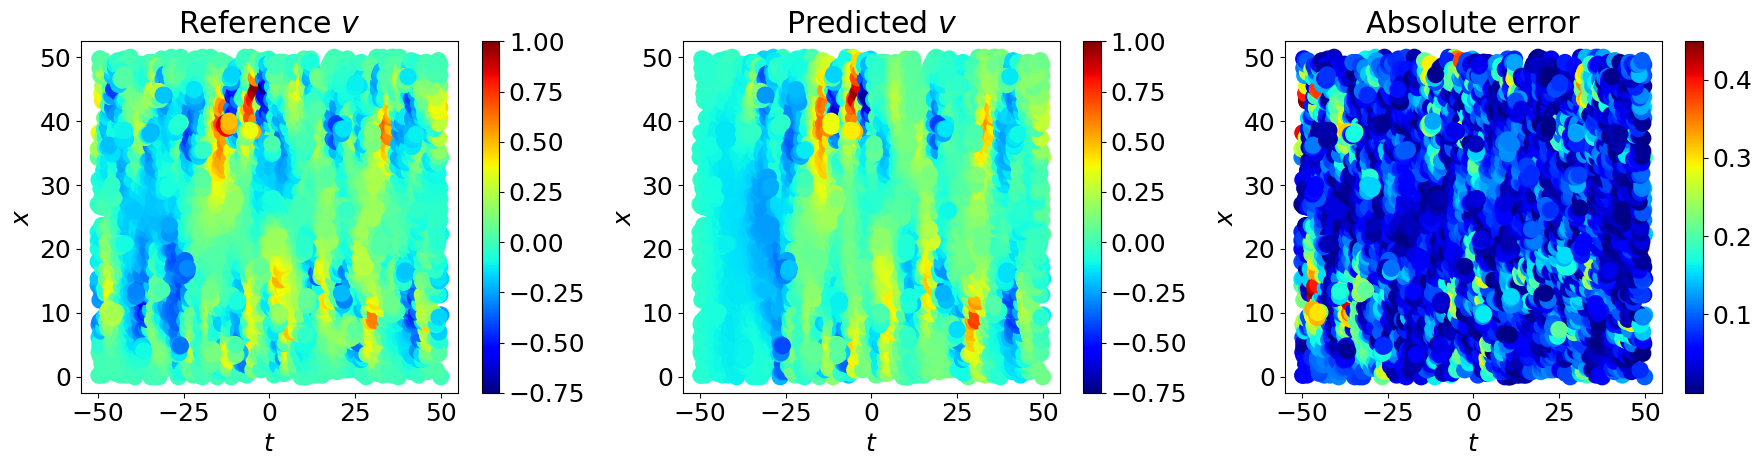

In [12]:

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
# plt.pcolor(yy, xx, u_star.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = v_star, s = 130, cmap='jet')
plt.colorbar()
plt.clim([-0.75, 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $v$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = v_pred, s = 130, cmap='jet')

plt.colorbar()
plt.clim([-0.75, 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $v$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, np.abs(u_true.reshape(xx.shape) - u_pred.reshape(xx.shape)), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = np.abs(v_star - v_pred), s = 130, cmap='jet')

plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.savefig('result_v.png', dpi=100)
plt.show()

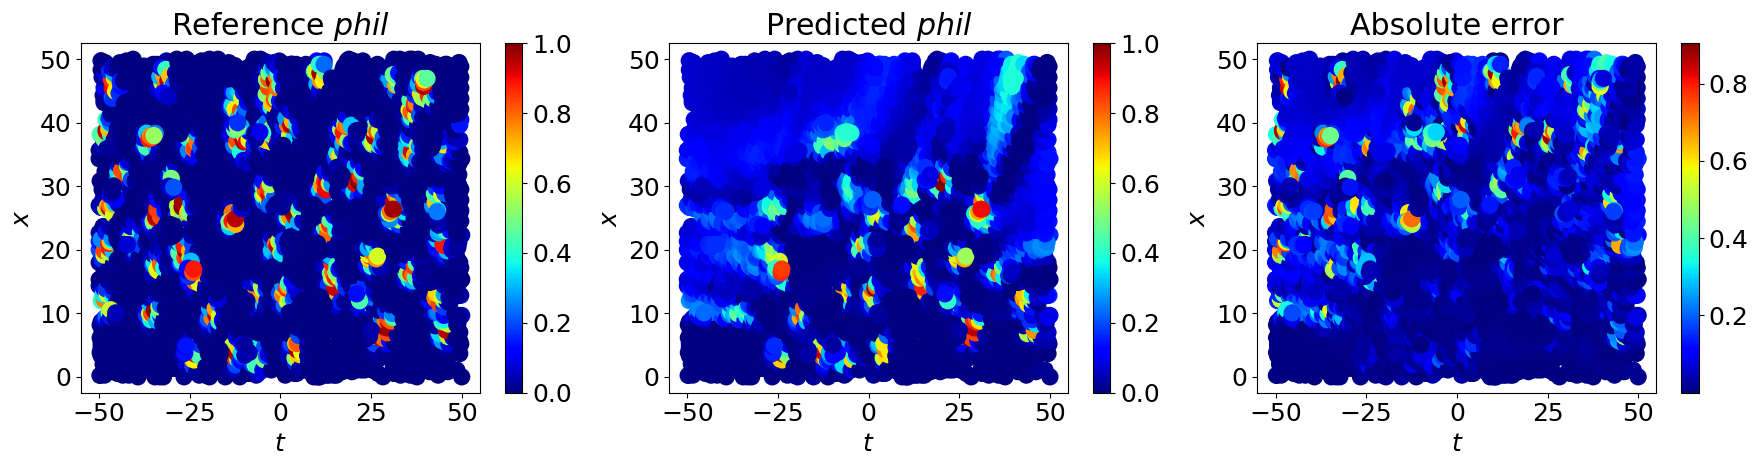

In [13]:

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
# plt.pcolor(yy, xx, u_star.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = phil_star, s = 130, cmap='jet')
plt.colorbar()
plt.clim([0., 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $phil$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = phil_pred, s = 130, cmap='jet')

plt.colorbar()
plt.clim([0., 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $phil$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, np.abs(u_true.reshape(xx.shape) - u_pred.reshape(xx.shape)), cmap='jet')
plt.scatter(X_star[:,0],X_star[:,1], c = np.abs(phil_star - phil_pred), s = 130, cmap='jet')

plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.savefig('result_phil.png', dpi=100)
plt.show()